# Laboratory #09 : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   You will have to mount your drive if you need to access images.
*   **Once you have the code completed, use GPU to train model faster.**

---

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

# Constants

*   Change the path of the directories according to your drive location.

In [1]:
from skimage import color, data, io, segmentation
import numpy as np
import glob
import datetime
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import jaccard_score
import tensorflow as tf

tf.get_logger().setLevel('INFO')
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def plotImages(images, grid=(2, 2), figsize=(15, 9), **kwargs):
    f, ax = plt.subplots(grid[0], grid[1], figsize=figsize)
    for imageIdx, (title, image) in enumerate(images.items()):
        if grid[0] == 1:
            ax[imageIdx].set_title(title)
            ax[imageIdx].imshow(image, **kwargs)
            ax[imageIdx].axis('off')
        else:
            ax[imageIdx//grid[1]][imageIdx%grid[1]].set_title(title)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].imshow(image, **kwargs)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].axis('off')
    return f, ax

In [3]:
models_path = Path('models/')
models_path.mkdir(exist_ok=True)
train_img = './TrayDataset/XTrain'
train_mask = './TrayDataset/yTrain'
test_img = './TrayDataset/XTest'
test_mask = './TrayDataset/yTest'

*   Define the constants needed for training the model

In [4]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
infer_batch_size = 1
epochs = 15  # find the best epoch that works for this problem

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [5]:
import os

train_img_paths = sorted([
    os.path.join(train_img, fname) for fname in os.listdir(train_img)
    if fname.lower().endswith(".jpg")
])

train_mask_paths = sorted([
    os.path.join(train_mask, fname) for fname in os.listdir(train_mask)
    if fname.endswith(".png") and not fname.startswith(".")
])

test_img_paths = sorted([
    os.path.join(test_img, fname) for fname in os.listdir(test_img)
    if fname.lower().endswith(".jpg")
])

test_mask_paths = sorted([
    os.path.join(test_mask, fname) for fname in os.listdir(test_mask)
    if fname.endswith(".png") and not fname.startswith(".")
])

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

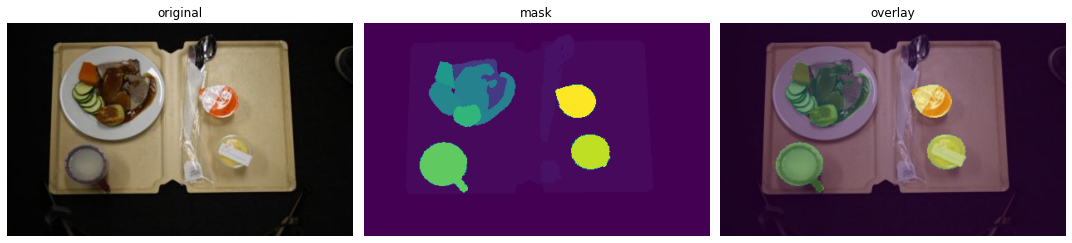

In [6]:
# solution
image_path, mask_path = train_img_paths[0], train_mask_paths[0]
image, mask = io.imread(image_path), io.imread(mask_path, as_gray=True)
images = {
    'original': image,
    'mask': mask,
    'overlay': image
}
_, ax = plotImages(images, grid=(1, 3), figsize=(15, 9))
ax[2].imshow(mask, alpha=0.4)
plt.tight_layout()
plt.show()

# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [7]:
# solution
class ImageGenerator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, batch_idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = batch_idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [8]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3, ))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2,
                                 padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes,
                            3,
                            activation="softmax",
                            padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [9]:
# Free up RAM in case the model definition cells were run multiple times
# keras.backend.clear_session()

In [10]:
# Build model

model = get_model(img_size, num_classes)

*   Print the summary of the model

In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator
*   Instantiate image generator for each data split.

In [12]:
# solution
train_gen = ImageGenerator(batch_size=batch_size, 
                           img_size=img_size, 
                           input_img_paths=train_img_paths, 
                           target_img_paths=train_mask_paths)
test_gen = ImageGenerator(batch_size=infer_batch_size, 
                          img_size=img_size, 
                          input_img_paths=test_img_paths,
                          target_img_paths=test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [13]:
# solution
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

*   Instantiate a ModelCheckpoint callback to save only the best model

In [17]:
class EarlyStoppingByLossVal(keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', ntries=5, minvalue=0.5, verbose=False):
        super(EarlyStoppingByLossVal, self).__init__()
        self.monitor = monitor
        self.value = None
        self.minvalue = minvalue
        self.verbose = verbose
        self.ntries = ntries
        self.ntries_counter = 0

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)
        
        if self.value is None and current >= self.minvalue:
            return
        elif self.value is None and current < self.minvalue:
            self.value = current
        elif self.value <= current:
            self.ntries_counter += 1
            if self.verbose:
                print(f"Model has not improved for {self.ntries_counter}/{self.ntries} epochs")
            if self.ntries_counter >= self.ntries:
                self.model.stop_training = True
                if self.verbose:
                    print(f"Epoch {epoch}: early stopping")
        else:
            self.ntries_counter = 0
            self.value = current
            if self.verbose:
                print(f"Model improved, reseting counter")

In [18]:
# solution
callbacks = [
    keras.callbacks.ModelCheckpoint(models_path / "segmentation.h5", save_best_only=True),
    EarlyStoppingByLossVal(ntries=10)
]

*   Train the model using fit method

In [19]:
# solution
# Train Snippet
epochs = 1000
hist = model.fit(train_gen, epochs=epochs, validation_data=test_gen, callbacks=callbacks)

# copy model extracted with date and val_acc in filename
cp_path = models_path / f"segmentation_{datetime.datetime.now().strftime('%m-%d-%Y')}_{min(hist.history.get('val_loss')):.3f}.h5"
shutil.copy(models_path/"segmentation.h5", cp_path)

# Load Previously trained model
# model.load_weights(models_path / "segmentation.h5")  # model can be loaded from previous executions

Epoch 1/1000
38/38 [==============================] - 14s 369ms/step - loss: 1.0780 - acc: 0.5544 - val_loss: 7.7310 - val_acc: 0.9911
Epoch 2/1000
38/38 [==============================] - 14s 363ms/step - loss: 0.6437 - acc: 0.5499 - val_loss: 7.7555 - val_acc: 0.9996
Epoch 3/1000
38/38 [==============================] - 14s 362ms/step - loss: 0.5262 - acc: 0.5483 - val_loss: 7.7505 - val_acc: 1.0000
Epoch 4/1000
38/38 [==============================] - 14s 365ms/step - loss: 0.4447 - acc: 0.5462 - val_loss: 8.2408 - val_acc: 0.2704
Epoch 5/1000
38/38 [==============================] - 14s 365ms/step - loss: 0.3821 - acc: 0.5470 - val_loss: 8.6935 - val_acc: 0.2372
Epoch 6/1000
38/38 [==============================] - 14s 367ms/step - loss: 0.3644 - acc: 0.5462 - val_loss: 7.7462 - val_acc: 1.0000
Epoch 7/1000
38/38 [==============================] - 14s 370ms/step - loss: 0.3086 - acc: 0.5460 - val_loss: 7.7217 - val_acc: 1.0000
Epoch 8/1000
38/38 [==============================] - 1

38/38 [==============================] - 14s 376ms/step - loss: 0.0743 - acc: 0.5457 - val_loss: 0.2119 - val_acc: 0.5174
Epoch 62/1000
38/38 [==============================] - 14s 371ms/step - loss: 0.0736 - acc: 0.5458 - val_loss: 0.2287 - val_acc: 0.5149
Epoch 63/1000
38/38 [==============================] - 14s 372ms/step - loss: 0.0751 - acc: 0.5456 - val_loss: 0.2190 - val_acc: 0.5169
Epoch 64/1000
38/38 [==============================] - 14s 367ms/step - loss: 0.0703 - acc: 0.5456 - val_loss: 0.2374 - val_acc: 0.5163
Epoch 65/1000
38/38 [==============================] - 14s 365ms/step - loss: 0.0726 - acc: 0.5457 - val_loss: 0.2326 - val_acc: 0.5177
Epoch 66/1000
38/38 [==============================] - 14s 365ms/step - loss: 0.0703 - acc: 0.5457 - val_loss: 0.2373 - val_acc: 0.5173
Epoch 67/1000
38/38 [==============================] - 14s 376ms/step - loss: 0.0694 - acc: 0.5456 - val_loss: 0.2142 - val_acc: 0.5224
Epoch 68/1000
38/38 [==============================] - 15s 383

# Visualize predictions



In [29]:
val_gen = ImageGenerator(batch_size=infer_batch_size,
                         img_size=img_size,
                         input_img_paths=test_img_paths,
                         target_img_paths=test_mask_paths)

*   Generate predictions for all images in the validation set

In [30]:
# solution
val_preds = model.predict(val_gen)

*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.

In [31]:
# solution
def masks_from_predictions(val_preds, axis=-1):
    return np.argmax(val_preds, axis=axis)
val_preds_masks = masks_from_predictions(val_preds)
print("val_preds_masks shape: ", val_preds_masks.shape)

val_preds_masks shape:  (8, 160, 160)


*   Read the test mask images to create the ground truth

In [32]:
# solution
val_gt_masks = np.array([target_batch.squeeze(0) for _, target_batch in val_gen]).squeeze(-1)
print("ground truth shape: ", val_gt_masks.shape)

ground truth shape:  (8, 160, 160)


*   For each validation image, find the jaccard similarity score

In [33]:
# solution
for pred, gt in zip(val_preds_masks, val_gt_masks):
    js = jaccard_score(pred.flatten(), gt.flatten(), average='micro')
    print(js)

0.8937012242482524
0.9229324720198302
0.8040238187519819
0.9583094281889463
0.8591815243836014
0.8710031061575004
0.8174718682332895
0.9439592983521907


*   What do you understand from the 'average' parameter?
*   What are the different values of 'average' parameter? 
*   Which parameter is used for what type of problem?

**Solution**

average : string, \[None, 'binary' (default), 'micro', 'macro', 'samples', 'weighted'\]
    If ``None``, the scores for each class are returned. Otherwise, this
    determines the type of averaging performed on the data:

- 'binary':

    Only report results for the class specified by ``pos_label``.
    This is applicable only if targets (``y_{true,pred}``) are binary.

- 'micro':

    Calculate metrics globally by counting the total true positives,
    false negatives and false positives.
    
- 'macro':
    
    Calculate metrics for each label, and find their unweighted
    mean.  This does not take label imbalance into account.
    
- 'weighted':
    
    Calculate metrics for each label, and find their average, weighted
    by support (the number of true instances for each label). This
    alters 'macro' to account for label imbalance.
    
- 'samples':
    
    Calculate metrics for each instance, and find their average (only
    meaningful for multilabel classification).

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib 

In [34]:
print(np.unique(val_gt_masks.flatten()))
print(np.unique(val_preds_masks.flatten()))

[ 0  1  2  7  8  9 10 11 12 13 14 15 16 17 18 19 22 24 25 26 27 28 29 30
 31 33 34 35 36 37 40 41 42]
[ 0  1  2  7  8  9 10 12 14 15 16 17 18 19 22 24 25 26 27 28 29 30 31 33
 34 35 36 37 40 41 42]


/home/victorbadenas/anaconda3/envs/CV3.7/lib/python3.7/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting int64 to int16 without scaling because max value 42 fits in int16
  return _convert(image, np.int16, force_copy)


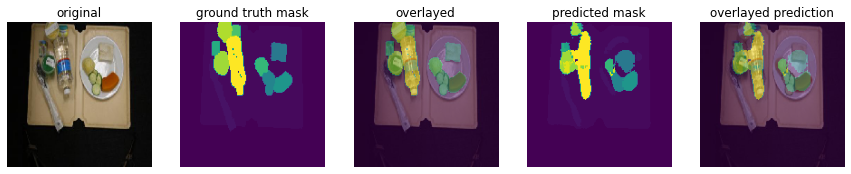

In [35]:
# solution
import random
from skimage.util import img_as_int
idx = random.randint(0, len(test_mask_paths)-1)
original_image = load_img(test_img_paths[idx], target_size=img_size)
images = {
    'original': original_image,
    'ground truth mask': val_gt_masks[idx],
    'overlayed': original_image,
    'predicted mask': img_as_int(val_preds_masks[idx]),
    'overlayed prediction': original_image
}
f, ax = plotImages(images, grid=(1,5), figsize=(15, 9))
ax[2].imshow(val_gt_masks[idx], alpha=0.5)
ax[4].imshow(val_preds_masks[idx], alpha=0.5)
plt.show()

*   What are other evaluation metrics to compare the performance of segmentation?

**Solution**

*(Double-click or enter to edit)*

...

# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

In [ ]:
# solution

*   How accurate are the prediction masks?
*   What happens to the unlabelled classes?

**Solution**

*(Double-click or enter to edit)*

...

*   What are the challenges when you use a trained model in the wild?
*   How can you develop a model to be used in real world?

**Solution**

*(Double-click or enter to edit)*

...

# Data Annotation using Labelme

*   Labelme is a GUI based image annotation tool which provides labeling for instance segmentation, semantic segmentation, bounding box detection and classification tasks.
*   Install labelme in your local machine (https://github.com/wkentaro/labelme)
*   Simple tutorial for single image example: https://github.com/wkentaro/labelme/tree/master/examples/tutorial
*   Semantic Segmentation example: https://github.com/wkentaro/labelme/tree/master/examples/semantic_segmentation

# Annotation for Tray food segmentation

*   Create labels.txt file that contains all the labels present in the tray food segmentation
*   *Hint: classes.csv file is present in the dataset folder*
*   *Check the labels file format in the semantic segmentation example* 

In [ ]:
# solution

*   Use the labels.txt file in the labelme annotation studio and create annotations for the images you collected.
*   Save the annotations in a directory containing the label image and the label visualization (overlayed image).

In [ ]:
# solution

*   Convert the label.png of each image to grayscale format (similar to ytrain in the tray segmentation dataset).

In [ ]:
# solution

*   For each image, show the annotation you created, annotation overlayed on the original image, predicted mask, predicted mask overlayed on the original image using matplotlib plot.

In [ ]:
# solution

*   Using the annotation you created, calculate the jaccard similarity score for each image.

In [ ]:
# solution

*   What are the challenges in data annotation (as an annotator)?

**Solution**

*(Double-click or enter to edit)*

...

*   What are the challenges in data annotation (as a computer vision engineer who builds models using annotated data)?

**Solution**

*(Double-click or enter to edit)*

...

*   Are annotations always accurate? What types of errors occur with annotation in general?

**Solution**

*(Double-click or enter to edit)*

...


---

## **End of P9: Image Segmentation using UNet**
Deadline for P9 submission in CampusVirtual is: **Thursday, the 17th of December, 2020**